In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('apartments.csv')
column_names = data.columns
data.head()

,Price,Bedrooms,Bathrooms,Size
0,ZMW2400000,3.0,2.5,80m²
1,ZMW3250000,3.0,1.0,150m²
2,ZMW5500000,2.0,NaN,1600m²
3,ZMW550000,1.0,1.0,57m²
4,ZMW22100000,NaN,NaN,4000m²


In [3]:
data['Price'] = data['Price'].str.extract('(\d+)').astype(float)
data['Price'] = data['Price'] * 0.03514186

data = data[(data['Price'] >= 5000) & (data['Price'] <= 1000000)]

In [4]:
def size_cleared(value):
    if isinstance(value, (float, int)):
        return float(value)
    elif 'm²' in value:
        return float(value.replace('m²', '').strip())
    elif 'acres' in value:
        acres = float(value.replace('acres', '').strip())
        return acres * 4046.86
    else:
        return np.nan

data['Size'] = data['Size'].apply(size_cleared)
data = data[(data['Size'].isna()) | ((data['Size'] >= 15) & (data['Size'] <= 0.5e+07))]

In [5]:
data = data[(data['Bathrooms'] <= 6) & (data['Bedrooms'] <= 5)]

In [6]:
data.describe()

,Price,Bedrooms,Bathrooms,Size
count,138.000000,138.000000,138.000000,57.000000
mean,120184.273231,2.543478,1.952899,891.120351
std,137602.919136,0.651999,0.688508,843.530236
min,15813.837000,1.000000,1.000000,57.000000
25%,49198.604000,2.000000,2.000000,460.000000
50%,73797.906000,3.000000,2.000000,600.000000
75%,131342.701750,3.000000,2.000000,1200.000000
max,773120.920000,4.000000,4.000000,4046.860000


In [7]:
mode_bedrooms = data['Bedrooms'].mode()[0]
data['Bedrooms'] = data['Bedrooms'].fillna(mode_bedrooms)

mode_bathrooms = data['Bathrooms'].mode()[0]
data['Bathrooms'] = data['Bathrooms'].fillna(mode_bathrooms)

# VIZUALIZACIJA

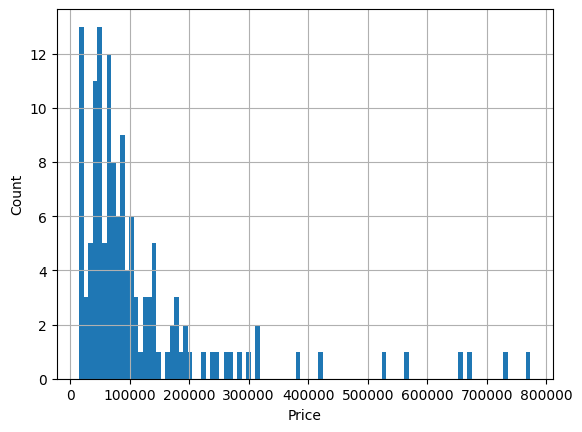

In [8]:
data["Price"].hist(bins=100)
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

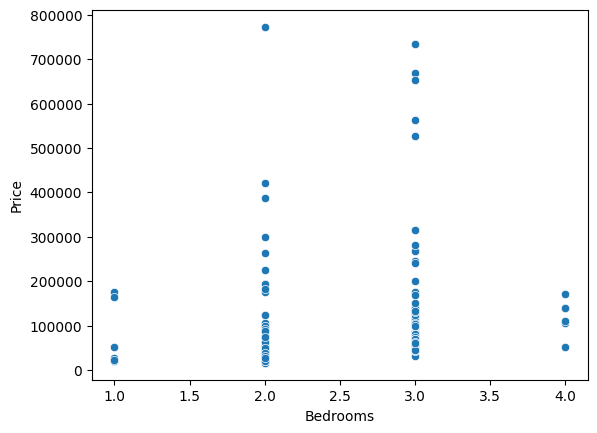

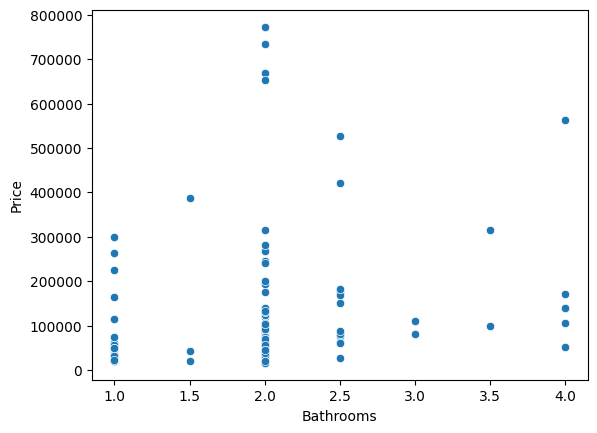

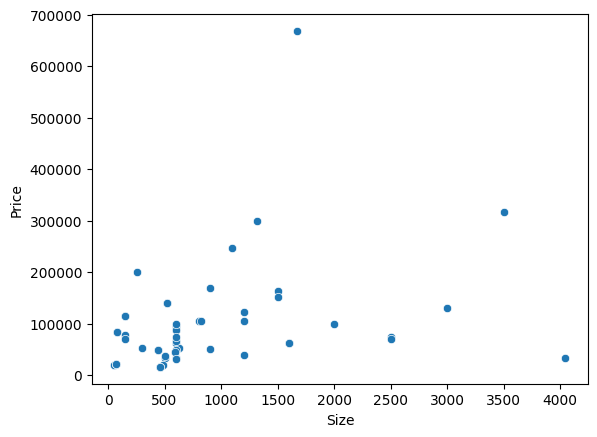

In [9]:
for i, col in enumerate(column_names[1:]):
    plt.figure(i)
    sns.scatterplot(data, x=str(col), y='Price')

### PODATKE S PODATKOM O VELIKOSTI UPORABIM KOT UČNE, PREOSTALIM BOM IZRAČUNALA VELIKOST

In [10]:
X_train = data.dropna(subset=['Size']).drop('Size', axis=1).to_numpy()

y_train = data.dropna(subset=['Size'])['Size'].to_numpy()
y_train = y_train[:, None]

X_pred = data[data['Size'].isna()].drop('Size', axis=1).to_numpy()

C:\Users\tanja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


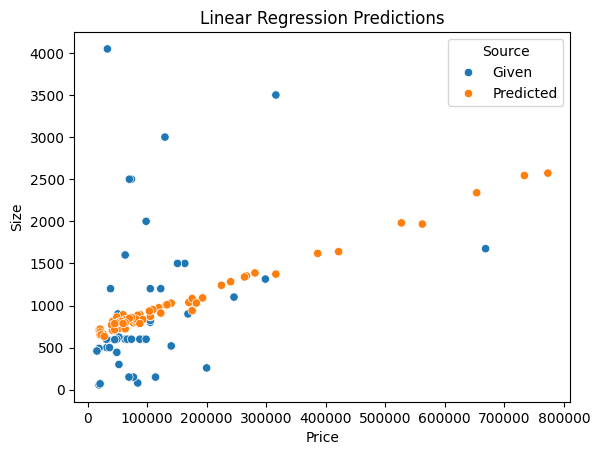

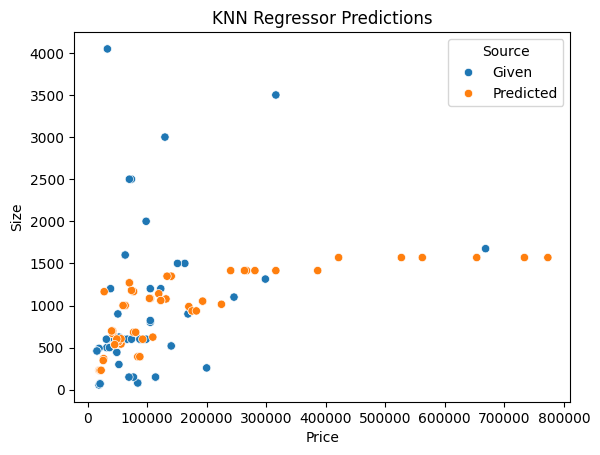

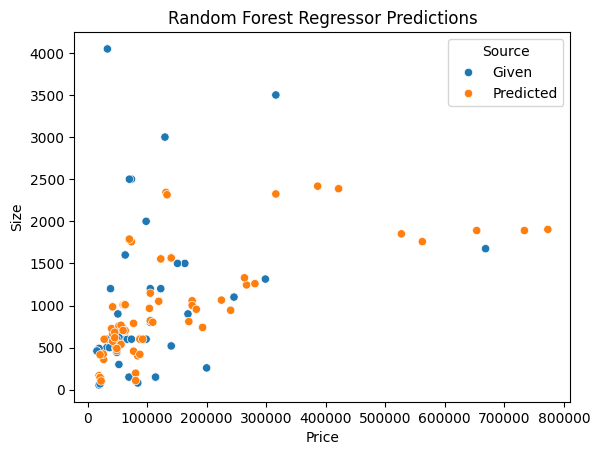

In [11]:
np.random.seed(7)
# Models initialization
models = {
    'Linear Regression': LinearRegression(),
    'KNN Regressor': KNeighborsRegressor(),
    'Random Forest Regressor': RandomForestRegressor()#oob_score=True
}

predictions = pd.DataFrame(columns=list(models.keys()))

# Predictions and plotting
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_pred)
    
    # Create DataFrame for predictions
    y_pred = pd.DataFrame(y_pred, columns=[column_names[-1]])
    predictions[model_name] = y_pred
    data_pred = pd.concat([pd.DataFrame(X_pred, columns=column_names[:-1]), y_pred], axis=1)
    
    # Add 'Source' column
    data_pred['Source'] = 'Predicted'
    
    # Combine with actual data
    data_combined = pd.concat([data.dropna(subset=['Size']).copy(), data_pred])
    data_combined.loc[:, 'Source'] = data_combined['Source'].fillna('Given')
    
    # Plot
    plt.figure()
    sns.scatterplot(data=data_combined, x='Price', y='Size', hue='Source')
    plt.title(f'{model_name} Predictions')
    
plt.show()


<Axes: xlabel='Size', ylabel='Price'>

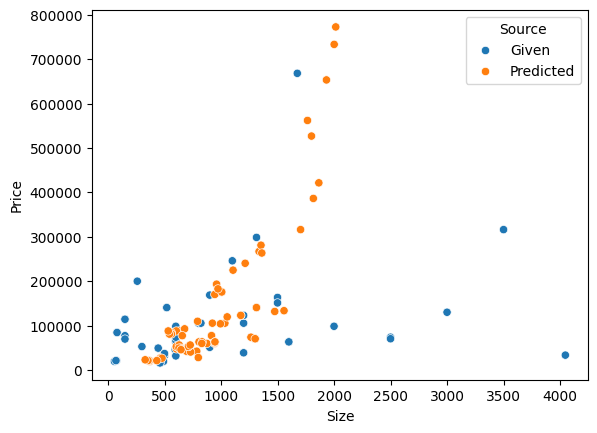

In [12]:
predictions['Size'] = predictions.mean(axis=1)

size = pd.DataFrame(predictions['Size'])

size_pred = pd.concat([pd.DataFrame(X_pred, columns=column_names[:-1]), size], axis=1)
size_pred['Source'] = 'Predicted'

data_full = pd.concat([data.dropna(subset=['Size']).copy(), size_pred])
data_full.loc[:, 'Source'] = data_full['Source'].fillna('Given')

sns.scatterplot(data_full, x='Size', y='Price', hue='Source')


## USING MACHINE LEARNING FOR PRICE PREDICTION

In [13]:
X = data_full.drop(['Price', 'Source'], axis=1).to_numpy()
X_dummy = pd.get_dummies(data_full, columns = ['Bathrooms', 'Bedrooms']).drop(['Price', 'Source'], axis=1)
X_dummy = X_dummy.to_numpy()
y = data_full['Price'].to_numpy()

X_norm = data_full.drop(['Price', 'Source'], axis=1)
X_norm['Size'] = (X_norm['Size'] - np.mean(X_norm['Size']))/(np.std(X_norm['Size']))
X_norm = X_norm.to_numpy()

X_size = data_full['Size'].to_numpy()
X_rooms = data_full[['Bedrooms', 'Bathrooms']].to_numpy()

In [14]:
np.random.seed(7)

# Initialize KFold object with 5 splits
kfold = KFold(n_splits=5, shuffle=True)

# Initialize lists to store errors for each model and each dataset
lr_errors = {'X': [], 'X_dummy': [], 'X_norm': [], 'X_rooms': [], 'X_size': []}
knn_errors = {'X': [], 'X_dummy': [], 'X_norm': [], 'X_rooms': [], 'X_size': []}
rf_errors = {'X': [], 'X_dummy': [], 'X_norm': [], 'X_rooms': [], 'X_size': []}

datasets = {'X': X, 'X_dummy': X_dummy, 'X_norm': X_norm, 'X_rooms': X_rooms, 'X_size': X_size}

# Loop through each dataset
for dataset_name, dataset in datasets.items():
    
    # Loop through each fold
    for i, (train_index, test_index) in enumerate(kfold.split(dataset)):
        if dataset_name == 'X_size':
            x_train = dataset[train_index]
            x_train = x_train[:, None]
            y_train = y[train_index]
            x_test = dataset[test_index]
            x_test = x_test[:, None]
            y_test = y[test_index]

        else:
            # Split data into training and testing sets
            x_train = dataset[train_index, :]
            y_train = y[train_index]
            x_test = dataset[test_index, :]
            y_test = y[test_index]
        
        # Linear Regression
        lr_model = LinearRegression().fit(x_train, y_train)
        y_pred_lr = lr_model.predict(x_test)
        lr_error = np.sqrt(mean_squared_error(y_test, y_pred_lr))
        lr_errors[dataset_name].append(lr_error)
    
        # KNeighborsRegressor
        knn_model = KNeighborsRegressor().fit(x_train, y_train)
        y_pred_knn = knn_model.predict(x_test)
        knn_error = np.sqrt(mean_squared_error(y_test, y_pred_knn))
        knn_errors[dataset_name].append(knn_error)
    
        # RandomForestRegressor
        rf_model = RandomForestRegressor().fit(x_train, y_train)
        y_pred_rf = rf_model.predict(x_test)
        rf_error = np.sqrt(mean_squared_error(y_test, y_pred_rf))
        rf_errors[dataset_name].append(rf_error)

# Print mean RMSE for each model and each dataset
for dataset_name in datasets.keys():
    print(f"Dataset: {dataset_name}")
    print(f"Mean RMSE Linear Regression ({dataset_name}): {np.mean(lr_errors[dataset_name])}")
    print(f"Mean RMSE KNeighborsRegressor ({dataset_name}): {np.mean(knn_errors[dataset_name])}")
    print(f"Mean RMSE RandomForestRegressor ({dataset_name}): {np.mean(rf_errors[dataset_name])}")


Dataset: X
Mean RMSE Linear Regression (X): 116359.73468657622
Mean RMSE KNeighborsRegressor (X): 91248.70890934631
Mean RMSE RandomForestRegressor (X): 82014.17938356627
Dataset: X_dummy
Mean RMSE Linear Regression (X_dummy): 126935.55003000148
Mean RMSE KNeighborsRegressor (X_dummy): 97217.57922132216
Mean RMSE RandomForestRegressor (X_dummy): 78610.76845283675
Dataset: X_norm
Mean RMSE Linear Regression (X_norm): 118257.52506224788
Mean RMSE KNeighborsRegressor (X_norm): 99054.41846479216
Mean RMSE RandomForestRegressor (X_norm): 78900.50429737348
Dataset: X_rooms
Mean RMSE Linear Regression (X_rooms): 127714.92768346178
Mean RMSE KNeighborsRegressor (X_rooms): 127629.56801088798
Mean RMSE RandomForestRegressor (X_rooms): 132647.8288454875
Dataset: X_size
Mean RMSE Linear Regression (X_size): 118781.90124868695
Mean RMSE KNeighborsRegressor (X_size): 102258.84736390787
Mean RMSE RandomForestRegressor (X_size): 96477.08132862826
